Load data

In [97]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

batch_size = 4

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [107]:
from model_task2c import PR_CNN

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR


net = PR_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.5)

In [110]:
num_epochs = 10

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        curr_lr = optimizer.param_groups[0]['lr']
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] LR:{curr_lr} loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    scheduler.step()

print('Finished Training')

[1,  4000] LR:0.0015625 loss: 0.080
[1,  8000] LR:0.0015625 loss: 0.084
[1, 12000] LR:0.0015625 loss: 0.089
[2,  4000] LR:0.00078125 loss: 0.079
[2,  8000] LR:0.00078125 loss: 0.085
[2, 12000] LR:0.00078125 loss: 0.079
[3,  4000] LR:0.000390625 loss: 0.076
[3,  8000] LR:0.000390625 loss: 0.087
[3, 12000] LR:0.000390625 loss: 0.081
[4,  4000] LR:0.0001953125 loss: 0.077
[4,  8000] LR:0.0001953125 loss: 0.076
[4, 12000] LR:0.0001953125 loss: 0.081
[5,  4000] LR:9.765625e-05 loss: 0.083
[5,  8000] LR:9.765625e-05 loss: 0.077
[5, 12000] LR:9.765625e-05 loss: 0.075
[6,  4000] LR:4.8828125e-05 loss: 0.076
[6,  8000] LR:4.8828125e-05 loss: 0.081
[6, 12000] LR:4.8828125e-05 loss: 0.076
[7,  4000] LR:2.44140625e-05 loss: 0.078
[7,  8000] LR:2.44140625e-05 loss: 0.077
[7, 12000] LR:2.44140625e-05 loss: 0.082
[8,  4000] LR:1.220703125e-05 loss: 0.077
[8,  8000] LR:1.220703125e-05 loss: 0.076
[8, 12000] LR:1.220703125e-05 loss: 0.079
[9,  4000] LR:6.103515625e-06 loss: 0.076
[9,  8000] LR:6.103515

In [28]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

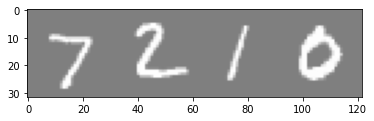

GroundTruth:  7     2     1     0    


In [27]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [30]:
net = PR_CNN()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  7     2     1     0    


In [31]:
correct = 0

total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 96 %
